# Campesan Giulia-2027592 
# NNDL 2021/2022 
## 3rd Homework
## Outline
* [Introduction](#Introduction)
* [CartPole](#Cart)
    * [Methods](#Cart-Methods)
    * [Results](#Cart-Results)
* [LunarLander](#Lander)
    * [Methods](#Lander-Methods)
    * [Results](#Lander-Results)


### Libraries import

In [1]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import json
import ast

from torch import nn
from collections import deque


import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor


import math as m

from matplotlib import animation

## Introduction<a class="anchor" id="Introduction"></a>

In this notebook, we exploit reinforcement learning based architecture to tackle two different problems: 
* the equilibrium of a pole over a cart moving in 1D,
* the correct landing of a lunar probe.


The chosen approach is Q-learning:
an agent, through a set of actions $\{ a_1, a_2, \dots, a_n\}$,  operates on the environment E, the state of which is known via its observations $\{ o_1, o_2, \dots, o_n\}$ at each time step t.
The effect of the agent actions on the environment can be quantified by a reward value $r_t$. 
The goal of reinforcement learning is to maximize the long-term reward.
In Q-learning, the agent learns to associate a value Q to each state-action pair, that takes into account both the short and long term reward: 
$$Q(s_t, a_t)\rightarrow Q(s_t, a_t)+\alpha [r_{t+1}+\gamma \max_a Q(s_{t+1}, a_t)-Q(s_t, a_t)]$$

In particular, we need a policy to determine which action to take at each step, based on the obtained Q-values for a fixed state. In order to explore the space this is done probabilistically: the exploration-exploitation trade off shall be taken into account in the policy choice. 

The two policies considered here are: 
* $\epsilon$-greedy policy, that will choose the best action (based on Q-value) with probability $1-\epsilon$
* soft-max policy, that selects the action to undertake from a set based on the relative Q-values, controlled by a temperature parameter.

In order to explore the state-action space, both the epsilon and the temperature parameters controlling the policies follow an exponential decay, from an initial value to 0.

Their trends are displayed below.




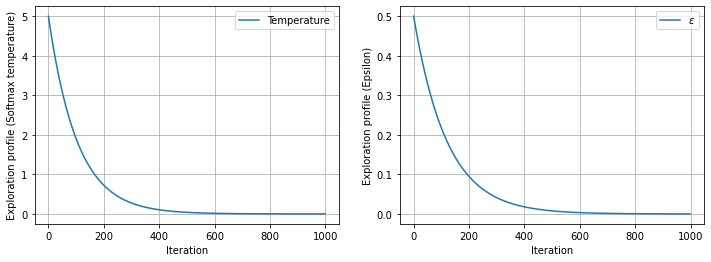

In [27]:
def temperature_profile(initial_value=5, num_iterations=1000):
    exp_decay = np.exp(-np.log(initial_value) / ( num_iterations ) * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
    exploration_profile = [initial_value * (exp_decay ** (i ) )for i in range(num_iterations)]
    return exploration_profile


def epsilon_profile(initial_value=0.5, num_iterations=1000):
    exp_decay = np.exp(np.log(initial_value) / ( num_iterations ) * 12) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
    exploration_profile = [initial_value * (exp_decay ** (i ) )for i in range(num_iterations)]
    return exploration_profile

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

### Plot exploration profile

axs[0].plot(temperature_profile(), label='Temperature')
axs[0].grid()
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Exploration profile (Softmax temperature)')
axs[0].legend()

axs[1].plot(epsilon_profile(), label=r'$\epsilon$')
axs[1].grid()
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Exploration profile (Epsilon)')
axs[1].legend()

plt.show()



## Cart Pole <a class="anchor" id="Cart"></a>

The first setting we are working on is the Cart Pole one in the gym environment. 
It is documented as follows:

_A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center._

The state space has size 4 and contains the cart position and velocity and the pole angular position and velocity $$O=[x, v_x, \theta, \omega]$$, whereas the possible actions are either 'push the cart to the right' or 'push the cart to the left', $$A=[R, L].$$

+1 reward is gained at each time step at which the pole is kept in position and the goal is achieved with a total reward of 500.

Here, we display a frame with the starting position.

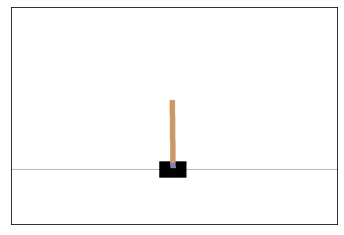

In [3]:
def get_screen(env):
    ''' Extract one step of the simulation.'''
    rgb_weights = [0.2989, 0.5870, 0.1140]
    # Get RGB
    # Images are 600x400 pixels
    screen = env.render(mode='rgb_array')#.transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.
    return screen

env = gym.make('CartPole-v1') 
state = env.reset()
screen = get_screen(env)
env.close()
plt.imshow(screen)
plt.yticks([])
plt.xticks([])
plt.show()

In [4]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


### Random agent
At first, let's try to play with a random agent, that will perform a random action despite the forecast reward.
We see that the game end after at most 35 time steps, meaning that the random agent is clearly not able to win the game.

In [5]:
# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
      # Choose a random action
      action = random.choice([0, 1])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      #env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()


EPISODE 1 - FINAL SCORE: 15.0
EPISODE 2 - FINAL SCORE: 20.0
EPISODE 3 - FINAL SCORE: 16.0
EPISODE 4 - FINAL SCORE: 12.0
EPISODE 5 - FINAL SCORE: 17.0
EPISODE 6 - FINAL SCORE: 17.0
EPISODE 7 - FINAL SCORE: 33.0
EPISODE 8 - FINAL SCORE: 15.0
EPISODE 9 - FINAL SCORE: 18.0
EPISODE 10 - FINAL SCORE: 29.0


### Methods <a class="anchor" id="Cart-Methods"></a>

We use a Deep Q-Network (DQN) to calculate Q-values. However, this approach turns out to be unstable and is not able to face the criticalities of this task: the training set is created incrementally, training samples are highly correlated and the target function is non-stationary. 

To face this issues, two workarounds are exploited:
* two networks are mantained: a prediction network that is trained at each step and generate Q-values, and a target network used for action selection, which is periodically updated (using the prediction networks weights).

* a memory buffer is used to store previous learning episodes, from which batches of state-action-reward-state tuples are randomly sampled. 


The network structure for both the prediction and target network is the following:

$$\begin{aligned}
\begin{array}{ |c| }
     \hline  
      Linear(4, \quad 128)  \\
     \hline
      Linear(128 \quad 128)  \\
     \hline
     Linear(128 \quad 2)  \\
     \hline     
\end{array}
\end{aligned}$$


The activation function is set to Tanh.
As exploration policy, the softmax policy with exponential decaying temperature is chosen.
The reward is updated at each time step, adding 1 point if the pole has mantained the equilibrium. Moreover, the reward is lowered by two penalties: one constraining the pole to stay vertical and the other preventing the cart to escape from the rail. They are built by removing a score proportional, respectively, to the pole angle $\theta$ and the cart linear position $x$.
The exploited optimizer is SGD.

The memory buffer capability is 1000 samples and the target network is updated every 10 steps.


In order to tune its hyper-parameters, a grid-search procedure is applied. 
In particular the search regards:
* the starting temperature,
* the angle and linear position penalties,
* the gamma parameter,
* the learning rate,
* the batch size.



In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)
    
    
    
def choose_action_epsilon_greedy(net, state, epsilon):

    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')

      # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

      # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
      # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

      # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
          # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
          # Select randomly
        action = random.choice(non_optimal_actions)
    else:
          # Select best action
        action = best_action

    return action, net_out.numpy()

def choose_action_softmax(net, state, temperature):
  
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
      
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)

    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    temperature = max(temperature, 1e-8) 
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
              
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) 
    return action, net_out.numpy()


In [6]:
def set_seeds(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


def initialize(replay_memory_capacity, state_space_dim, action_space_dim, params):

    ### Initialize the replay memory
    replay_mem = ReplayMemory(replay_memory_capacity)    

  ### Initialize the policy network
    policy_net = DQN(state_space_dim, action_space_dim)

  ### Initialize the target network with the same weights of the policy network
    target_net = DQN(state_space_dim, action_space_dim)
    target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

  ### Initialize the optimizer
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=params['lr']) # The optimizer will update ONLY the parameters of the policy network

  ### Initialize the loss function (Huber loss)
    loss_fn = nn.SmoothL1Loss()

    return policy_net, target_net, optimizer, loss_fn, replay_mem


In [7]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch

    states  = np.array( [s[0] for s in batch], dtype=np.float32 )
    states = torch.from_numpy(states)

    actions = np.array([s[1] for s in batch], dtype=np.int64)
    actions = torch.from_numpy(actions)

    rewards = np.array([s[3] for s in batch], dtype=np.float32)
    rewards = torch.from_numpy(rewards)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = np.array([s[2] for s in batch if s[2] is not None], dtype=np.float32) # the next state can be None if the game has ended
    non_final_next_states = torch.from_numpy(non_final_next_states)

    non_final_mask = np.array([s[2] is not None for s in batch], dtype=bool)
    non_final_mask = torch.from_numpy(non_final_mask)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [8]:
def training_loop(env, exploration_profile, replay_mem,  pos_weight, angle_weight, bad_state_penalty, 
                  policy_net, target_net, optimizer, loss_fn, params, verbose, render_flag=False):


    training_score = []


    for episode_num, tau in enumerate(tqdm(exploration_profile)):

        state = env.reset()
        score = 0
        done = False

      

      # Go on until the pole falls off
        while not done:

            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            # We apply a (linear) penalty when the cart is far from center
            reward = reward - pos_weight * np.abs(state[0]) - angle_weight * np.abs(state[2])

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward += bad_state_penalty
                next_state = None


            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > params['min_samples_for_training']: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, params['gamma'], optimizer, loss_fn, params['batch_size'])

            # Visually render the environment (disable to speed up the training)
            if render_flag:
                env.render()

            # Set the current state for the next iteration
            state = next_state

      # Update the target network every target_net_update_steps episodes
        if episode_num % params['target_net_update_steps'] == 0:
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

      # Print the final score
        training_score.append(score)

        if (verbose==True):
             if episode_num % params['target_net_update_steps'] == 0:
                print('Updating target network...')
             print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score


    env.close()

    return policy_net, training_score


In [ ]:
seed = 0
set_seeds(seed)



gamma = np.linspace(0.9, 0.99, 10)
lr = np.logspace(-3, -1, 10)
batch_size = [32, 64, 128, 256]
#target_net_update_steps = np.arange(5, 25, 5, dtype=int)
pos_weight_vctr = np.arange(0, 4)
angle_weight_vctr = np.arange(0, 4)
init_value_vctr = np.arange(4, 9)
replay_memory_capacity = 10000 




results_list = []


for _ in range(10):

    env = gym.make('CartPole-v1') 
    env.seed(seed) 

    initial_value = int(np.random.choice(init_value_vctr))
    exploration_profile = temperature_profile(initial_value)
    angle_weight = int(np.random.choice(angle_weight_vctr))
    pos_weight = int(np.random.choice(pos_weight_vctr))

    params = {}
    params['gamma'] = float(np.random.choice(gamma))  # gamma parameter for the long term reward
    params['lr'] = float(np.random.choice(lr) )
    params['batch_size'] = int(np.random.choice(batch_size)) # Number of samples to take from the replay memory for each update
    params['angle_weight'] = angle_weight
    params['pos_weight'] = pos_weight



    # Optimizer learning rate
    params['target_net_update_steps'] = 10   # Number of episodes to wait before updating the target network
    bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
    params['min_samples_for_training'] = 1000 





    policy_net, target_net, optimizer, loss_fn, replay_mem = initialize(replay_memory_capacity, state_space_dim, action_space_dim, params)



    policy_net, training_score = training_loop(env, exploration_profile, replay_mem, pos_weight, angle_weight, bad_state_penalty, 
                    policy_net, target_net, optimizer, loss_fn, params, verbose=False)


    results = {}
    results['params'] = params
    results['exploration'] = exploration_profile#np.array(exploration_profile)
    results['score'] = training_score#np.array(training_score)

    results_list.append(results)





filename = "results/results_cartPole.json"

results_file = open(filename, "w")
json.dump(results_list, results_file)
results_file.close()







In [28]:

filename = 'results/results_cartPole.json'
with open(filename) as f:
    data = ast.literal_eval(f.read())
  

### Results <a class="anchor" id="Cart-Results"></a>

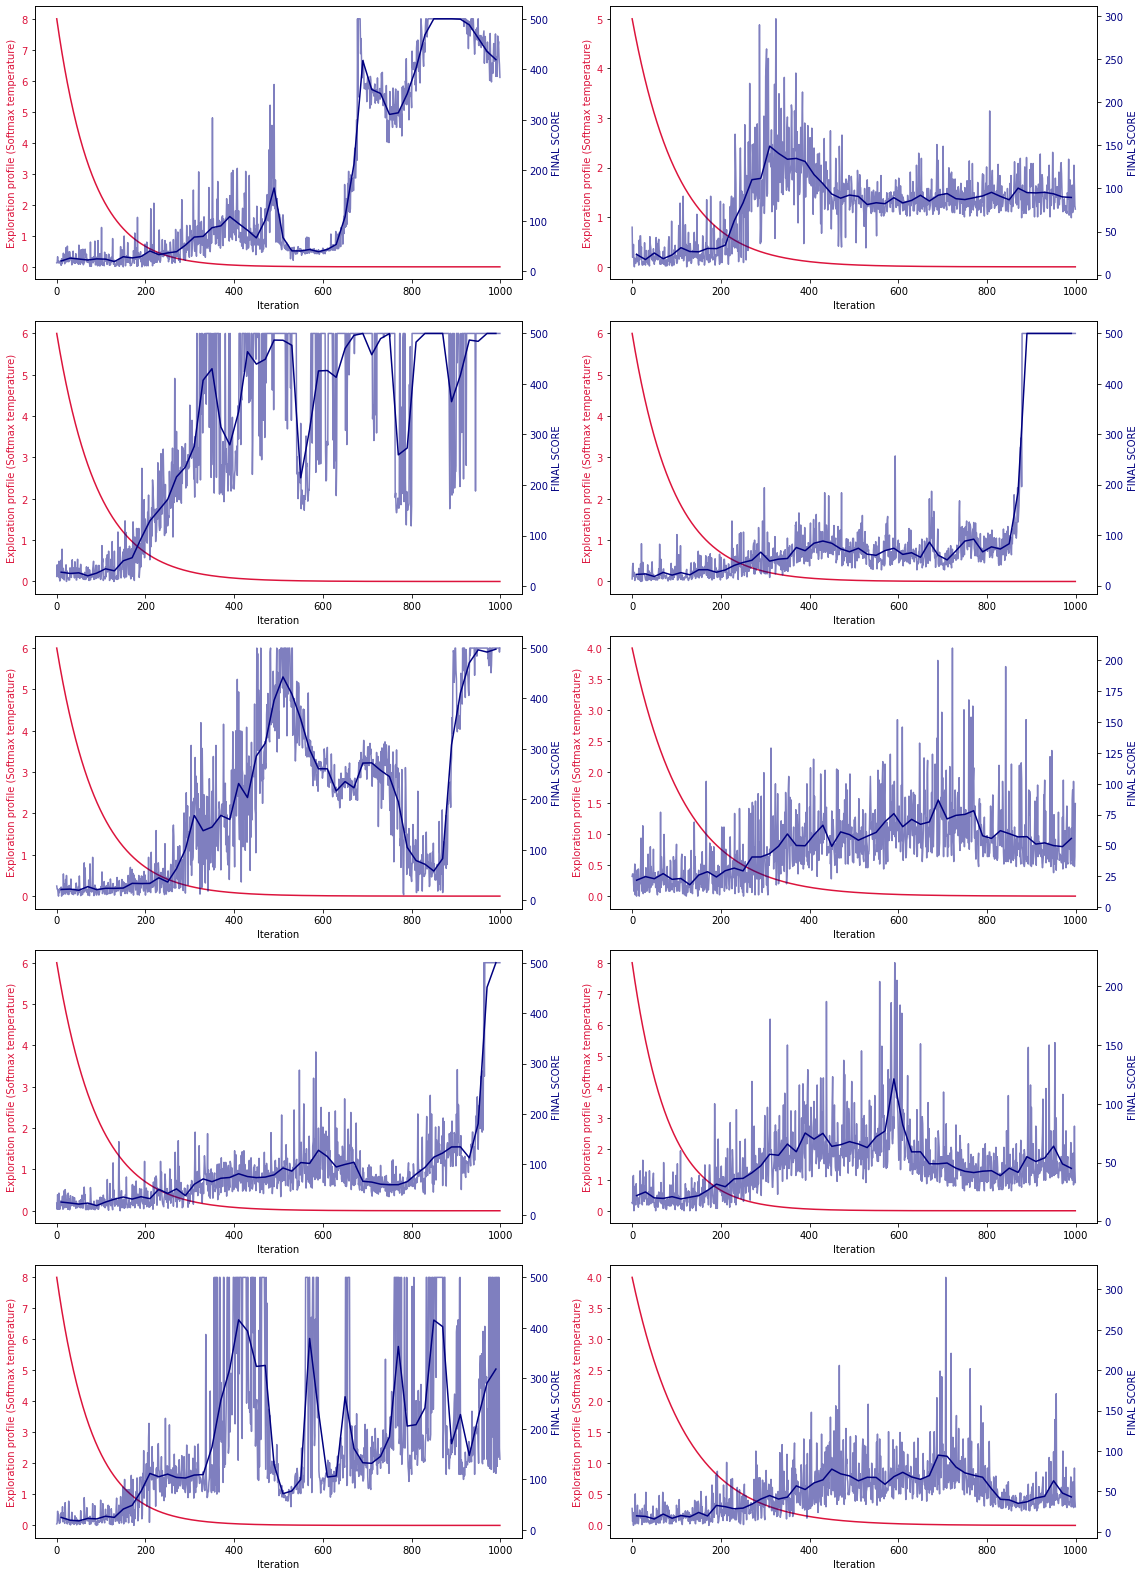

In [10]:
def averaging(signal, freq=20):
    signal = np.array(signal)
    new_signal = []
    new_pos = []
    for i in range(len(signal)//freq):
        new_signal.append( signal[i*freq:(i+1)*freq].mean() )
        new_pos.append( (i*freq+(i+1)*freq)/2 )
        
    return new_pos, new_signal



fig, axs = plt.subplots(5, 2, figsize=(16, 22))



for i in range(len(data)):
  #plt.plot(data[i]['score'])
  #plt.show()

    color = 'crimson'
    ax1 = axs[m.floor(i/2), i%2 ]
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Exploration profile (Softmax temperature)', color=color)
    ax1.plot(data[i]['exploration'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'navy'
    x, y = averaging(data[i]['score'])
    ax2.plot(x, y , color=color)
    ax2.set_ylabel('FINAL SCORE', color=color)  # we already handled the x-label with ax1
    ax2.plot(data[i]['score'], color=color, alpha=0.5)
    ax2.tick_params(axis='y', labelcolor=color)
    

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    #plt.show()

Here, we report the achieved score for each of the 10 trials performed via grid search.
In each plot, both the temperature and score profiles are reported. Moreover, as the score is particularly noisy, the moving average performed over 20 sequential iterations is displayed.

As the best configuration, we could choose the one that leads to the fastest convergence. However, we see that it is pretty unstable. Then, our choice falls for the set of parameters that leads to stable convergence.

The values are the following:
* starting temperature: $6$
* the angular position penalty: $1$
* the linear position penalty: $2$
* $\gamma$ parameter: $0.96$
* the learning rate: $4\cdot 10^{-3}$
* the batch size: 256

Then, we test this best configuration at 0 temperature and retrieve the fianl score for 10 trials: we see that each one retrieve a final score of 500. 

Finally, a GIF of the pole behaviour when controlled by this network is displayed.

In [11]:
def first_solved(score):
    solved = score[np.where(score>=490)]
    thrsld = len(score)-len(solved)
    
    return thrsld
solutions = []
for i in range(len(data)):
    solutions.append(first_solved(np.array(data[i]['score'])))

    
fastest_combo =  np.argmin(solutions)  
    
print(f'the {fastest_combo+1} parameters combination has the fastest convergence after {np.min(solutions)} iterations')
print(f'the best set of hyperparameters is', data[fastest_combo]['params'])

the 3 parameters combination has the fastest convergence after 528 iterations
the best set of hyperparameters is {'gamma': 0.96, 'lr': 0.1, 'batch_size': 64, 'angle_weight': 3, 'pos_weight': 1, 'target_net_update_steps': 10, 'min_samples_for_training': 1000}


In [29]:
best_combo =  3  
    
print(f'the {best_combo+1} parameters combination has the most stable convergence')
print(f'the best set of hyperparameters is', data[best_combo]['params'])

the 4 parameters combination has the most stable convergence
the best set of hyperparameters is {'gamma': 0.95, 'lr': 0.004641588833612777, 'batch_size': 256, 'angle_weight': 1, 'pos_weight': 2, 'target_net_update_steps': 10, 'min_samples_for_training': 1000}


In [15]:
env = gym.make('CartPole-v1') 
env.seed(0)

params = data[best_combo]['params']
replay_memory_capacity = 10000 
bad_state_penalty=0


policy_net, target_net, optimizer, loss_fn, replay_mem = initialize(replay_memory_capacity, state_space_dim, action_space_dim, params)

exploration_profile = data[best_combo]['exploration']

policy_net, training_score = training_loop(env, exploration_profile, 
                                           replay_mem, params['pos_weight'], params['angle_weight'], 
                                           bad_state_penalty, 
                                           policy_net, target_net, optimizer, loss_fn, 
                                           params, verbose=False, render_flag=True)



  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0


In [17]:
def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

In [ ]:
env = gym.make('CartPole-v1')

#Run the env
observation = env.reset()
frames = []
for t in range(100):
    frames.append(env.render(mode="rgb_array"))
    action, q_values = choose_action_softmax(policy_net, state, temperature=0)
    next_state, reward, done, info = env.step(action)
    state = next_state
    
    if done:
        break
        
env.close()
save_frames_as_gif(frames, filename='cartPole.gif')

<img src="cartPole.gif" width="750" align="center">


## Lunar Lander <a class="anchor" id="Lander"></a>

The other setting we consider is the Lunar Lander one in the gym environment, as well.
It is  documented as follows:
_Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine._

The state space has now size 8 and contains the lander x and y coordinates, its horizontal and vertical speed components, its angle and angular velocity and two booleans encoding whether the first or second leg has touched the floor. 

$$O=[x, y, v_x, v_y, \theta, \omega, one, two]$$

The possible actions are, as listed above, to do nothing, to fire the left, the main or the right engine.

$$A=[\text{null}, l_e, m_e, r_e]$$
The goal is achieved with a total reward of 200.

Here, we display a frame with the starting position, having the lander at the top center. As first action, a random force is applied to its center of mass.

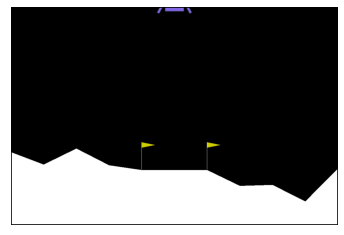

STATE SPACE SIZE: 8
ACTION SPACE SIZE: 4


In [58]:
### Create environment
env = gym.make('LunarLander-v2') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

 
state = env.reset()
screen = get_screen(env)
env.close()
plt.imshow(screen)
plt.yticks([])
plt.xticks([])
plt.show()

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

### Random agent
At first, let's try to play with a random agent, that will perform a random action despite the forecast reward.
We see that the total score is negative, meaning that the lander has crashed.

In [21]:
# Initialize the Gym environment
env = gym.make('LunarLander-v2')
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
      # Choose a random action
      action = random.choice([0, 1])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()


EPISODE 1 - FINAL SCORE: -456.0561032506905
EPISODE 2 - FINAL SCORE: -323.3258277189556
EPISODE 3 - FINAL SCORE: -525.8781987959414
EPISODE 4 - FINAL SCORE: -235.04261334046552
EPISODE 5 - FINAL SCORE: -298.80393394274813
EPISODE 6 - FINAL SCORE: -333.17758367890184
EPISODE 7 - FINAL SCORE: -487.25491969579105
EPISODE 8 - FINAL SCORE: -416.1272541118334
EPISODE 9 - FINAL SCORE: -241.0993444891063
EPISODE 10 - FINAL SCORE: -304.58677660922206


### Methods <a class="anchor" id="Lander-Methods"></a>

The approach is the one exploited also for the Cart Pole environment, using the same DQN network structure.

What changes here is, clearly, how the reward is assigned: in addition to the default assigned environment at each time step, a bonus and a penalty terms are added:
* the bonus encourages the probe to land, so it enahances the reward for states with negative vertical velocity $v_y$
* the penalty contraints the lander to stay at center, decreasing the rewards proprtionally to the absolute value of the $x$ coordinate. 
Moreover, a penalty is applied when the lander crashes ('bad_state_penalty').

Here, both soft-max and $\epsilon$-greedy policies are used and grid-search tuning is applied fot both approaches.

In [30]:
def training_loop(env, policy, exploration_profile, replay_mem,  center_weight, down_weight, bad_state_penalty, 
                  policy_net, target_net, optimizer, loss_fn, params, verbose):



  training_score = []

  # This is for creating the output video in Colab, not required outside Colab

  for episode_num, tau in enumerate(tqdm(exploration_profile)):

      # Reset the environment and get the initial state
      state = env.reset()
      # Reset the score. The final score will be the total amount of steps before the pole falls
      score = 0
      done = False



      while not done:

        # Choose the action following the policy
        action, q_values = policy(policy_net, state, tau)

        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)

        bonus = np.abs(state[3]) if state[3] <0 else 0
        reward = reward  - center_weight * np.abs(state[0]) + down_weight * bonus

        score += reward

        # Apply penalty for bad state
        if done: 
            reward += bad_state_penalty
            next_state = None


        # Update the replay memory
        replay_mem.push(state, action, next_state, reward)

        # Update the network
        if len(replay_mem) > params['min_samples_for_training']: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, params['gamma'], optimizer, loss_fn, params['batch_size'])

        # Visually render the environment (disable to speed up the training)
        #env.render()

        # Set the current state for the next iteration
        state = next_state

      # Update the target network every target_net_update_steps episodes
      if episode_num % params['target_net_update_steps'] == 0:
          target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

      # Print the final score
      training_score.append(score)

      if (verbose==True):
         if episode_num % params['target_net_update_steps'] == 0:
            print('Updating target network...')
         print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score


  env.close()

  return policy_net, training_score


### $\epsilon$-greedy policy

The tuning procedure for $\epsilon$-greedy policy, with starting value of 0.5 (random choice), involves: 
* the learning rate,
* the batch size,
* the number of steps between the update of the target net.

The other hyper-parameters are fixed and are set to:
* bonus for landing: 1.5
* penalty for moving far from center: 0.5
* bad state penalty: 0.8
* $\gamma: 0.99$
* memory buffer capability: 1000 samples

Again, the optimization algorithm is set to SGD.

By observing the score curves, we see that, despite being noisy, several of them display a good convergence trend, that can be visualized by the moving average performed on 20 sequential iterations.


In [ ]:
seed = 0
set_seeds(seed)



lr = np.logspace(-3, -1, 10)
batch_size = [32, 64, 128, 256]
target_net_update_steps = np.arange(5, 25, 5, dtype=int)




results_list = []


for _ in range(10):

  env = gym.make('LunarLander-v2') 
  env.seed(seed) 

  exploration_profile = epsilon_profile()
  center_weight = 0.5
  down_weight = 1.5

  params = {}
  params['gamma'] = 0.99#float(np.random.choice(gamma))  # gamma parameter for the long term reward
  params['lr'] = float(np.random.choice(lr) )
  params['batch_size'] = int(np.random.choice(batch_size)) # Number of samples to take from the replay memory for each update
  params['down_weight'] = down_weight
  params['center_weight'] = center_weight

  

    # Optimizer learning rate
  params['target_net_update_steps'] = int(np.random.choice(target_net_update_steps))  # Number of episodes to wait before updating the target network
  bad_state_penalty = 0.8   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
  params['min_samples_for_training'] = 500 
  replay_memory_capacity = 10000 





  policy_net, target_net, optimizer, loss_fn, replay_mem = initialize(replay_memory_capacity, state_space_dim, action_space_dim, params)



  policy_net, training_score = training_loop(env, choose_action_epsilon_greedy, exploration_profile, replay_mem, center_weight, down_weight, bad_state_penalty, 
                    policy_net, target_net, optimizer, loss_fn, params, verbose=False)
  

  results = {}
  results['params'] = params
  results['exploration'] = exploration_profile#np.array(exploration_profile)
  results['score'] = training_score#np.array(training_score)

  results_list.append(results)






filename = "results/results_lunarLander_epsgrd.json"

results_file = open(filename, "w")
json.dump(results_list, results_file)
results_file.close()
  

In [24]:
filename = "results/results_lunarLander_epsgrd.json"
#filename = 'drive/MyDrive/Homework3_NN/results_lunarLander.json'
with open(filename) as f:
    data = ast.literal_eval(f.read())

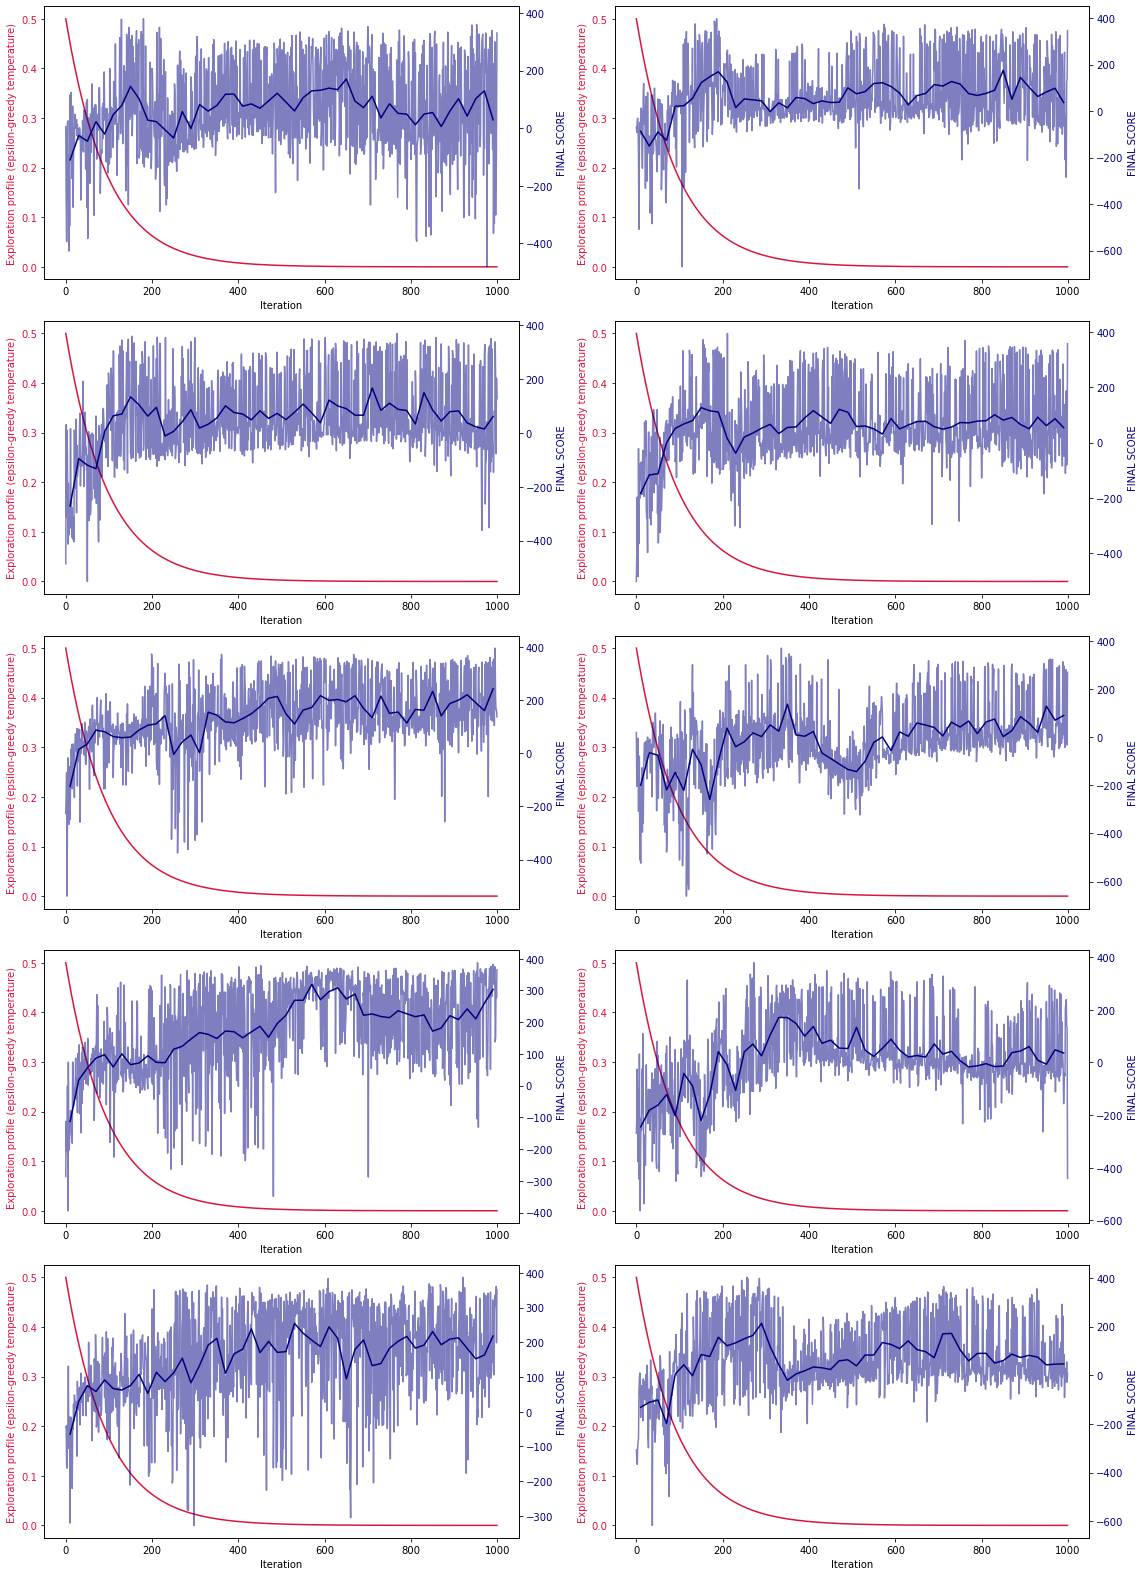

In [25]:
fig, axs = plt.subplots(5, 2, figsize=(16, 22))



for i in range(len(data)):
  #plt.plot(data[i]['score'])
  #plt.show()

    color = 'crimson'
    ax1 = axs[m.floor(i/2), i%2 ]
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Exploration profile (epsilon-greedy temperature)', color=color)
    ax1.plot(data[i]['exploration'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    
    x, y = averaging(data[i]['score'])
    
    

    color = 'navy'
    ax2.plot(x, y, color=color)
    ax2.set_ylabel('FINAL SCORE', color=color)  # we already handled the x-label with ax1
    ax2.plot(data[i]['score'], color=color, alpha=0.5)
    ax2.tick_params(axis='y', labelcolor=color)
    

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    #plt.show()

### Soft-max policy


The tuning procedure for the soft-max policy involves: 
* the starting temperature value,
* the learning rate,
* the batch size,
* the number of steps between the update of the target net.

The other hyper-parameters are fixed and are set to:
* bonus for landing: 1.5,
* penalty for moving far from center: 0.5,
* bad state penalty: 0.8,
* $\gamma: 0.99$,
* memory buffer capability: 1000 samples.

Again, the optimization algorithm is set to SGD.

By observing the score curves, we see that none of them is able to reach a value of 200, at which the game is won.

In [ ]:
seed = 0
set_seeds(seed)



lr = np.logspace(-3, -1, 10)
batch_size = [32, 64, 128, 256]
target_net_update_steps = np.arange(5, 25, 5, dtype=int)
init_value_vctr = np.arange(4, 9)


results_list = []


for _ in range(10):

  env = gym.make('LunarLander-v2') 
  env.seed(seed) 

  initial_value = int(np.random.choice(init_value_vctr))
  exploration_profile = temperature_profile(initial_value)
  center_weight = 0.5
  down_weight = 1.5
  params = {}
  params['gamma'] = 0.99 # gamma parameter for the long term reward
  params['lr'] = float(np.random.choice(lr) )
  params['batch_size'] = int(np.random.choice(batch_size)) # Number of samples to take from the replay memory for each update
  params['down_weight'] = down_weight
  params['center_weight'] = center_weight

  

    # Optimizer learning rate
  params['target_net_update_steps'] = int(np.random.choice(target_net_update_steps))  # Number of episodes to wait before updating the target network
  bad_state_penalty = 0.8   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
  params['min_samples_for_training'] = 500 
  replay_memory_capacity = 10000 





  policy_net, target_net, optimizer, loss_fn, replay_mem = initialize(replay_memory_capacity, state_space_dim, action_space_dim, params)



  policy_net, training_score = training_loop(env, choose_action_softmax, exploration_profile, replay_mem, center_weight, down_weight, bad_state_penalty, 
                    policy_net, target_net, optimizer, loss_fn, params, verbose=False)
  

  results = {}
  results['params'] = params
  results['exploration'] = exploration_profile#np.array(exploration_profile)
  results['score'] = training_score#np.array(training_score)

  results_list.append(results)






filename = "results/results_lunarLander_softmax.json"

results_file = open(filename, "w")
json.dump(results_list, results_file)
results_file.close()
  

In [27]:
filename = "results/results_lunarLander_softmax.json"
#filename = 'drive/MyDrive/Homework3_NN/results_lunarLander.json'
with open(filename) as f:
    data = ast.literal_eval(f.read())

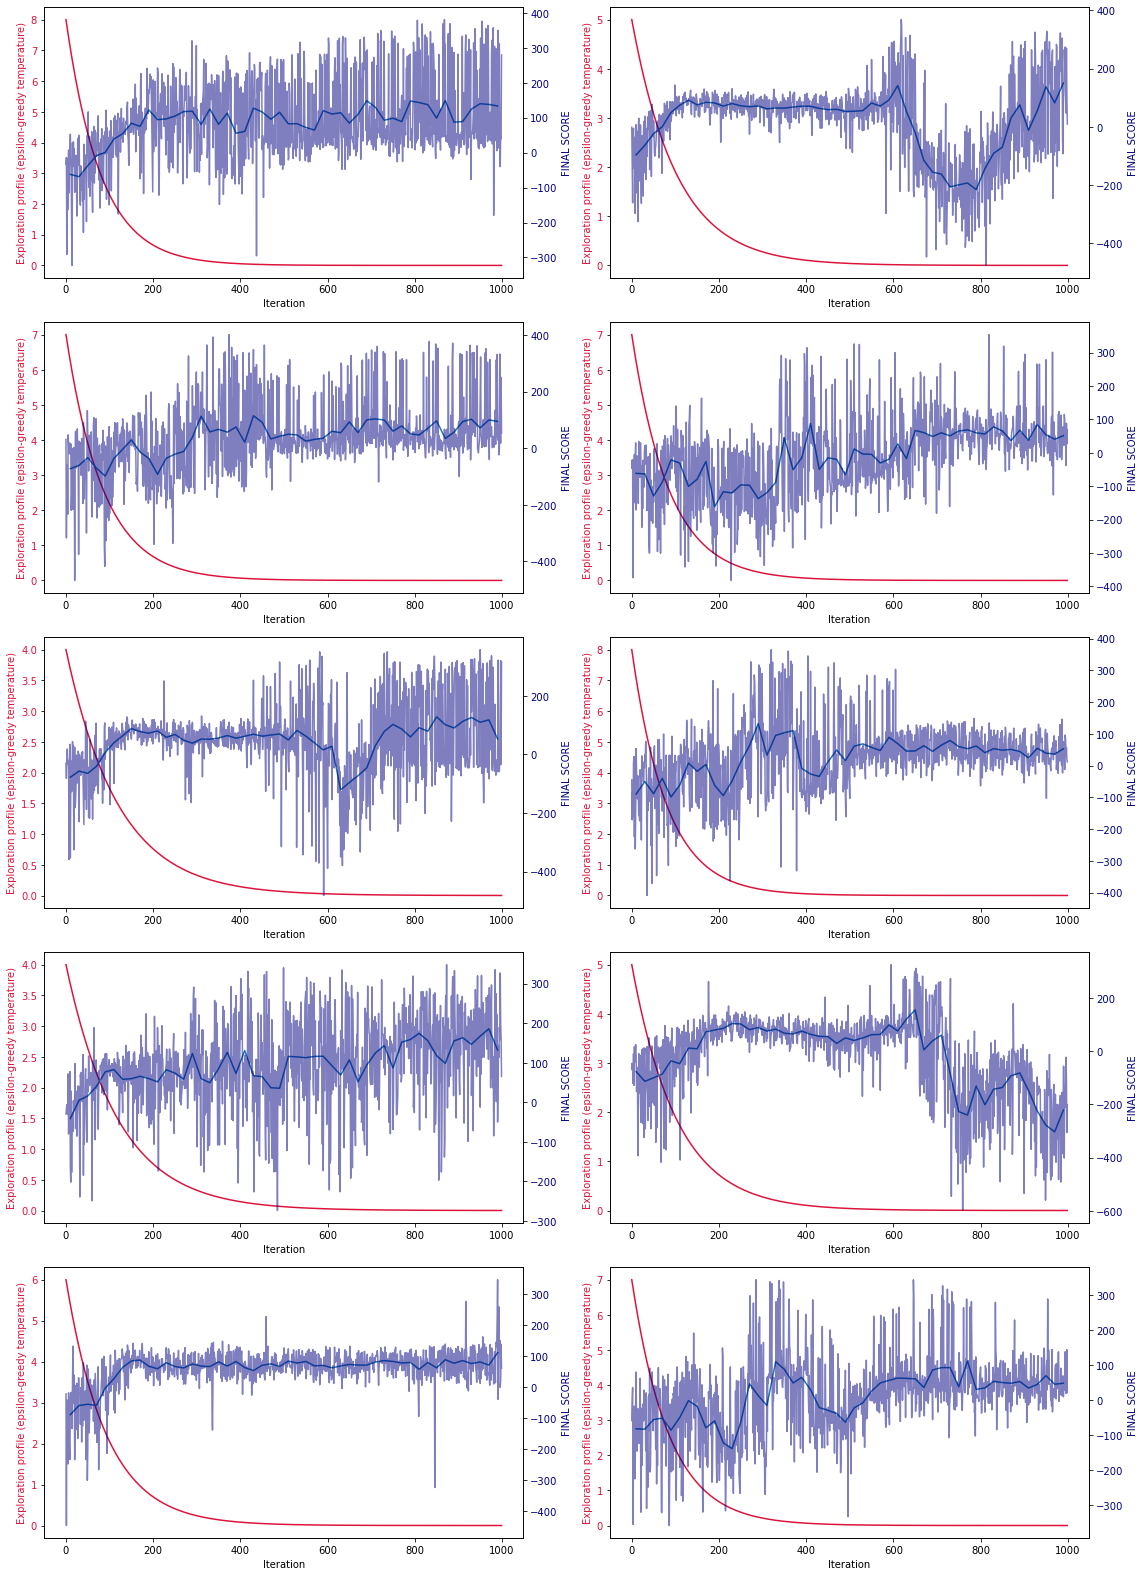

In [28]:

fig, axs = plt.subplots(5, 2, figsize=(16, 22))



for i in range(len(data)):
  #plt.plot(data[i]['score'])
  #plt.show()

    color = 'crimson'
    ax1 = axs[m.floor(i/2), i%2 ]
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Exploration profile (epsilon-greedy temperature)', color=color)
    ax1.plot(data[i]['exploration'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    

    color = 'navy'
    x, y = averaging(data[i]['score'])
    ax2.plot(x, y)
    ax2.set_ylabel('FINAL SCORE', color=color)  # we already handled the x-label with ax1
    ax2.plot(data[i]['score'], color=color, alpha=0.5)
    ax2.tick_params(axis='y', labelcolor=color)
    

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    #plt.show()

### Results  <a class="anchor" id="Lander-Results"></a>

The best configuration of parameters is selected from the $\epsilon$-greedy policy trials.

This configuration is the following: 
* learning rate: $6\cdot10^{-2}$
* update steps: 5
* batch size: 32

We train the policy and target networks using this set of parameters and evaluate their learning by retrieving the score for 10 episodes: we see that 8 out of 10 trials have a score over 200 and failures are due to noise. 

Finally, we display the landing phase with a GIF.

In [57]:
filename = "results/results_lunarLander_epsgrd.json"
#filename = 'drive/MyDrive/Homework3_NN/results_lunarLander.json'
with open(filename) as f:
    data = ast.literal_eval(f.read())

best_combo =  4  
    
print(f'the {best_combo+1} parameters combination has the most stable convergence after {np.min(solutions)} iterations')
print(f'the best set of hyperparameters is', data[best_combo]['params'])

the 5 parameters combination has the most stable convergence after 528 iterations
the best set of hyperparameters is {'gamma': 0.99, 'lr': 0.05994842503189409, 'batch_size': 32, 'down_weight': 1.5, 'center_weight': 0.5, 'target_net_update_steps': 5, 'min_samples_for_training': 500}


In [63]:
env = gym.make('LunarLander-v2') 
env.seed(0)

params = data[best_combo]['params']
exploration_profile = data[best_combo]['exploration']


policy_net, target_net, optimizer, loss_fn, replay_mem = initialize(replay_memory_capacity, 
                                                                  state_space_dim, 
                                                                  action_space_dim, 
                                                                  params)



policy_net, training_score = training_loop(env, 
                                         choose_action_softmax, 
                                         exploration_profile, 
                                         replay_mem, 
                                         params['center_weight'], 
                                         params['down_weight'], 
                                         bad_state_penalty, 
                                         policy_net, 
                                         target_net, 
                                         optimizer, 
                                         loss_fn, 
                                         params, verbose=False)




  0%|          | 0/1000 [00:00<?, ?it/s]

In [65]:
# Initialize the Gym environment
env = gym.make('LunarLander-v2') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 130.49280490160612
EPISODE 2 - FINAL SCORE: 249.45129354332607
EPISODE 3 - FINAL SCORE: 132.5641158637155
EPISODE 4 - FINAL SCORE: 9.05391694434931
EPISODE 5 - FINAL SCORE: 236.5524529752851
EPISODE 6 - FINAL SCORE: 234.69396369336354
EPISODE 7 - FINAL SCORE: 209.92294072494022
EPISODE 8 - FINAL SCORE: 260.0290160689788
EPISODE 9 - FINAL SCORE: 270.32117761334484
EPISODE 10 - FINAL SCORE: 267.56534809263405


In [ ]:
env = gym.make('LunarLander-v2')

#Run the env
observation = env.reset()
frames = []
for t in range(300):
    frames.append(env.render(mode="rgb_array"))
    action, q_values = choose_action_softmax(policy_net, state, temperature=0)
    next_state, reward, done, info = env.step(action)
    state = next_state
    
    if done:
        break
        
env.close()
save_frames_as_gif(frames, filename='new_lunarLander.gif')

<img src="new_lunarLander.gif" width="750" align="center">